In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import numpy as np
from scipy.special import comb

### Defining the siamese network

In [2]:
class Siamese(nn.Module):
    """
        The class for a siamese network. The network contains:
            1 - 3 convolutional layers with ReLU non-linearization
            2 - 2 max-pooling layers in between first and second, 
                and second and third convolutional layers
            3 - 2 fully connected layers
        
    """
    def __init__(self):
        """
            Initializing the network        
        """
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 2)
        
        self.lin1 = nn.Linear(1152, 512)
        self.lin2 = nn.Linear(512, 64)
    
    def forward(self, data):
        """
            Defining a forward pass of the network
        
            Parameters
            ----------
            data : torch.Tensor
                Input tensor for the network

            Returns
            -------
            x : torch.Tensor
                Output tensor from the network
                
        """
        # passing the data through first convolutional layer 
        # and applying non-linearization with ReLU
        x = self.conv1(data)
        x = F.relu(x)
        
        # max-pooling
        x = self.pool1(x)
        
        # passing the data through second convolutional layer 
        # and applying non-linearization with ReLU
        x = self.conv2(x)
        x = F.relu(x)
        
        # max-pooling
        x = self.pool2(x)
        
        # passing the data through third convolutional layer 
        # and applying non-linearization with ReLU
        x = self.conv3(x)
        x = F.relu(x)
        
        # flattening the data for fully connected layers
        x = x.view(-1,1152)
        
        # passing the data through first and second fully connected layers
        x = self.lin1(x)
        x = self.lin2(x)
        
        return x


### Defining the helper functions

In [3]:
def generate_training_batch(dataset, idx_label_array, start_idx, end_idx, pair_set):
    """
        Generating batches for training the siamese network. For each sample,
        this method finds a genuine and an impostor sample to create pairs. The
        genuine and impostor samples are selected randomly from the dataset.
        pair_set is used to keeping track of the selected pairs so that in the 
        next batches, the same pairs are not used.
        
        Parameters
        ----------
        dataset : torchvision.datasets.mnist.MNIST
            Dataset used to creating batches
        idx_label_array : numpy.ndarray
            Labels of all the samples in the dataset
        start_idx : int
            Number of comma values to divide between 0 and 1200 cent
        end_idx : int
            Whether to include the first and the last sections
        pair_set : set
            Set of index pairs
            
        Returns
        -------
        batch_1_x : torch.Tensor
            Values of the first batch
        batch_2_x : torch.Tensor
            Values of the second batch
        batch_1_y : torch.Tensor
            Labels of the first batch
        batch_2_y : torch.Tensor
            Labels of the second batch
        batch_c : torch.Tensor
            Contrastive labels for the pairs
        pair_set : set
            Updated set of index pairs
        
    """
    # size of the current batch
    batch_size = end_idx - start_idx
    
    # initializing batches
    batch_1_x = np.zeros((batch_size*2, 1, 28, 28))
    batch_2_x = np.zeros((batch_size*2, 1, 28, 28))
    batch_1_y = np.zeros((batch_size*2))
    batch_2_y = np.zeros((batch_size*2))
    
    # array for containing contrastive labels (e.g. 0 if genuine pair, 1 if impostor)
    batch_c = np.zeros((batch_size*2))
    
    for i in range(batch_size):
        # index of the current sample
        idx = i + start_idx
        
        # label of the current sample
        label = dataset[idx][1].item()
        
        # index of a random selected sample with the same label (for genuine pair)
        g_index = np.random.choice(np.where(idx_label_array==label)[0], size=1)[0]
        
        # index of a random selected sample with a different label (for impostor pair)
        i_index = np.random.choice(np.where(idx_label_array!=label)[0], size=1)[0]
        
        # checking if the selected genuine pair is selected before
        while set((idx, g_index)) in pair_set:
            g_index = np.random.choice(np.where(idx_label_array==label)[0], size=1)[0]
            
        # checking if the selected impostor pair is selected before
        while set((idx, i_index)) in pair_set:
            i_index = np.random.choice(np.where(idx_label_array!=label)[0], size=1)[0]
        
        # adding the current pairs to pair_set
        pair_set.add(frozenset((idx, g_index)))
        pair_set.add(frozenset((idx, i_index)))
        
        # adding the values and labels of the genuine pair to batches
        batch_1_x[i*2] = dataset[idx][0]
        batch_2_x[i*2] = dataset[g_index][0]
        batch_1_y[i*2] = label
        batch_2_y[i*2] = label
        
        # setting the contrastive label for the genuine pair
        batch_c[i*2] = 0
        
        # adding the values and labels of the impostor pair to batches
        batch_1_x[i*2+1] = dataset[idx][0]
        batch_2_x[i*2+1] = dataset[i_index][0]
        batch_1_y[i*2+1] = label
        batch_2_y[i*2+1] = dataset[i_index][1].item()
        
        # setting the contrastive label for the impostor pair
        batch_c[i*2+1] = 1
    
    # casting the batches from numpy arrays to float tensors
    batch_1_x = torch.from_numpy(batch_1_x).float()
    batch_2_x = torch.from_numpy(batch_2_x).float()
    batch_1_y = torch.from_numpy(batch_1_y).float()
    batch_2_y = torch.from_numpy(batch_2_y).float()
    batch_c = torch.from_numpy(batch_c).float()
        
    return batch_1_x, batch_2_x, batch_1_y, batch_2_y, batch_c, pair_set  
    

In [4]:
def generate_test_batch(dataset, sample_idx):
    """
        Generating batches for testing the siamese network. In order to do that, this function 
        creates pairs of samples to feed it in to the network. For ith element in the dataset 
        with the size N, this function creates pairs of ith element and (i+1)th element, ..., Nth 
        element of the dataset.
        
        Parameters
        ----------
        dataset : torchvision.datasets.mnist.MNIST
            Dataset used to creating batches
        sample_idx : int
            Index of the current sample to create a batch
            
        Returns
        -------
        batch_1_x : torch.Tensor
            Values of the first batch
        batch_2_x : torch.Tensor
            Values of the second batch
        
    """
    
    # number of the samples in the dataset
    num_of_samples = len(dataset)
    
    # size of the current batch

    batch_size = num_of_samples-sample_idx
    
    # initializing the batches
    batch_1_x = np.zeros((batch_size, 1, 28, 28))
    batch_2_x = np.zeros((batch_size, 1, 28, 28))
    
    # index for the current batch
    idx = 0
    for i in range(sample_idx, num_of_samples):
        # current batch contains the pairs of the current sample and the samples
        # coming after the current one
        batch_1_x[idx] = dataset[sample_idx][0]
        batch_2_x[idx] = dataset[i][0]
        idx += 1
            
    # casting the batches from numpy arrays to float tensors
    batch_1_x = torch.from_numpy(batch_1_x).float()
    batch_2_x = torch.from_numpy(batch_2_x).float()
        
    return batch_1_x, batch_2_x


In [5]:
def MAP(dist_matrix, labels):
    """
        Calculating Mean Average Precision given a symmetric pairwise distance matrix
        and labels of the rows/columns
        
        Parameters
        ----------
        dist_matrix : numpy.ndarray
            Symmetric distance matrix that contains pairwise distances
        labels : numpy.ndarray
            Labels of all the samples in the dataset
        
        Returns
        -------
        mAP : float
            Mean average precision obtained from the distance matrix
        
    """
    
    # number of samples in the dataset
    num_of_samples = labels.size
    
    # initializing a matrix to store tuples of pairwise distances and labels of the reference samples
    tuple_matrix = np.zeros((num_of_samples, num_of_samples), dtype=(float,2))
    
    # filling the tuple_matrix with distance values and labels
    for i in range(num_of_samples):
        for j in range(num_of_samples):
            tuple_matrix[i][j] = (dist_matrix[i][j], labels[j])
            
    # initializing mAP
    mAP = 0
    
    # calculating average precision for each row of the distance matrix
    for i in range(num_of_samples):
        # obtaining the current row
        row = tuple_matrix[i]
        
        # label of the current query
        label = labels[i]
        
        # sorting the row with respect to distance values
        sorted_row = row[row[:,0].argsort()]
        
        # initializing true positive count 
        tp = 0
        
        # initializing precision value
        prec = 0
        
        # counting number of instances that has the same label as the query
        label_count = 0
        
        for j in range(1, num_of_samples):
            # checking whether the reference sample has the same label as the query
            if sorted_row[j][1] == label:
                # incrementing the number of true positives
                tp += 1
                
                # updating the precision value
                prec += tp/j
                
                # incrementing the number of samples with the same label as the query
                label_count += 1
        
        # updating  mAP
        mAP += prec/label_count
        
    # updating mAP
    mAP = mAP / num_of_samples
    
    return mAP


### Loading train and test subsets

In [6]:
# creating a folder named 'data' to store the dataset
if not os.path.isdir('data/'):
    os.mkdir('data/')

# loading MNIST training set
mnist_trainset = torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# loading MNIST test set
mnist_testset = torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

Processing...
Done!


### Initializing the network and the variables

In [7]:
# initializing the siamese network
siamese = Siamese()

# initializing the optimization function
optimizer = optim.Adam(siamese.parameters(), lr=0.001)

# size of the training set
dataset_size = len(mnist_trainset)

# array of labels for training set
# used for creating training batches
idx_label_array = np.zeros(dataset_size, dtype='int')
for i in range(dataset_size):
    idx_label_array[i] = mnist_trainset[i][1].item()

# size of training batches
# note that actual batch size will be the double of this amount
batch_size = 32

# number of epochs to train
num_of_epochs = 1

# number of batches for each epoch
num_of_batches = np.ceil(dataset_size/batch_size).astype('int')

# genuine and impostor pairs for training
# keeping track in order to not to give same pairs
pair_set = set()

# loss function values for visualization
loss_log = []

### Training the network

In [8]:
# training the network for number of epochs
for epoch in range(num_of_epochs):
    # for each batch in the current epoch
    for batch_idx in range(int(num_of_batches)):
        # start index of the current batch
        start_idx = batch_idx*batch_size
        # end index of the current batch
        end_idx = min((batch_idx+1)*batch_size, dataset_size)
        
        # generating pairs for the current batch
        batch_1_x, batch_2_x, batch_1_y, batch_2_y, batch_c, pair_set = generate_training_batch(mnist_trainset, 
                                                                                                idx_label_array, 
                                                                                                start_idx, 
                                                                                                end_idx, 
                                                                                                pair_set)
        
        # setting gradients of the optimizer to zero
        optimizer.zero_grad()
        
        # output of the first batch
        res_1 = siamese(batch_1_x)
        
        # output of the second batch
        res_2 = siamese(batch_2_x)
        
        # euclidean distance between pairs
        dist = F.pairwise_distance(res_1, res_2)
        
        # contrastive loss function
        contrastive_loss = torch.mean((1 - batch_c) * torch.pow(dist, 2)
                                      + batch_c * torch.pow(torch.clamp(2 - dist, min=0.0), 2))
        
        # printing the loss for every 25 batch
        if batch_idx%25 == 0:
            loss_log.append(contrastive_loss.item())
            print('Current epoch: ', epoch)
            print('Current batch: {}/{}'.format(batch_idx, num_of_batches))
            print('Contrastive loss: {}\n'.format(contrastive_loss.item()))

        # calculating gradients with backpropagation
        contrastive_loss.backward()
        
        # updating the weights
        optimizer.step()
      

Current epoch:  0
Current batch: 0/1875
Contrastive loss: 1.6199431419372559

Current epoch:  0
Current batch: 25/1875
Contrastive loss: 0.4285477101802826

Current epoch:  0
Current batch: 50/1875
Contrastive loss: 0.46618005633354187

Current epoch:  0
Current batch: 75/1875
Contrastive loss: 0.48405417799949646

Current epoch:  0
Current batch: 100/1875
Contrastive loss: 0.44815507531166077

Current epoch:  0
Current batch: 125/1875
Contrastive loss: 0.34446218609809875

Current epoch:  0
Current batch: 150/1875
Contrastive loss: 0.2854847013950348

Current epoch:  0
Current batch: 175/1875
Contrastive loss: 0.30996373295783997

Current epoch:  0
Current batch: 200/1875
Contrastive loss: 0.297442227602005

Current epoch:  0
Current batch: 225/1875
Contrastive loss: 0.3142947554588318

Current epoch:  0
Current batch: 250/1875
Contrastive loss: 0.32156965136528015

Current epoch:  0
Current batch: 275/1875
Contrastive loss: 0.22850649058818817

Current epoch:  0
Current batch: 300/18

### Visualizing the loss evalution

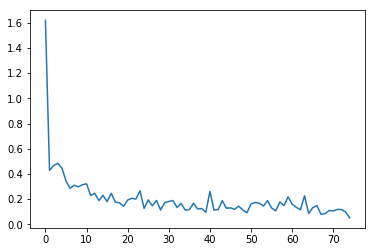

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_log)
plt.show()

### Testing the network

In [11]:
# creating a subset of the MNIST test set
test_subset = list()

# size of the subset
test_subset_size = 5000

# array for labels of the subset
test_subset_labels = np.zeros((test_subset_size))

# generating the test subset and the labels
for i in range(test_subset_size):
    test_subset.append(mnist_testset[i])
    test_subset_labels[i] = mnist_testset[i][1].item()

In [12]:
# deactivating gradient tracking for testing
with torch.no_grad():
    # setting the model to evaluation mode
    siamese.eval()
    
    # tensor for storing all the pairwise distances
    dist_all = torch.tensor([])
    
    for i in range(test_subset_size):
        # generating pairs for the current batch
        batch_1_x, batch_2_x = generate_test_batch(test_subset, i)
        
        # output of the first batch
        res_1 = siamese(batch_1_x)
        
        # output of the second batch
        res_2 = siamese(batch_2_x)
        
        # euclidean distance between pairs
        dist = F.pairwise_distance(res_1, res_2)
        
        # concatenating the current distance tensor with the previous distances
        dist_all = torch.cat((dist_all, dist))
        

### Evaluating the network

In [13]:
# initializing a symmetric distance matrix
dist_matrix = np.zeros((test_subset_size, test_subset_size))

# index counter for the distance tensor
counter = 0

for i in range(test_subset_size):
    for j in range(i, test_subset_size):
        
        # filling the distance matrix with pairwise distances
        dist_matrix[i][j] = dist_all[counter].item()
        dist_matrix[j][i] = dist_all[counter].item()
        counter += 1
        

In [14]:
# calculating mean average precision
mAP = MAP(dist_matrix,test_subset_labels)
print('Mean average precision is ', mAP)

Mean average precision is  0.9743064962807318
